## Graph Similarity Measures

In this exercise we will look at different local and global similarity measures and how they can be used to model graph structure. Further we will analyze the effectiveness of these measures for problems like link prediction on uni-relational dataset.

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from utils import mask_test_edges
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import numpy as np

In [19]:
# To get ROC score for test graph
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adjacency_repr[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adjacency_repr[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

We will use a small social network graph of karate club. The network captures 34 members of a karate club, documenting 78 pairwise links between members who interacted outside the club

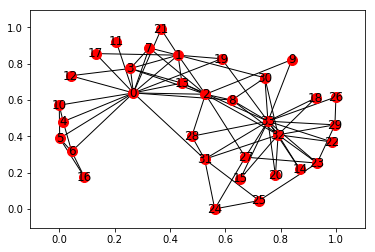

In [20]:
# Analysis with karate graph
G=nx.karate_club_graph()
nx.draw_networkx(G, node_size=100)
plt.show()

We will mask some interactions in graph while retaining the main structure. Further, we will analyze different similarity measures for this graph and report the effectiveness on masked edges.

In [21]:
# Adjacency Matrix for Graph
adjacency_repr = nx.to_scipy_sparse_matrix(G)

# Perform train-test split
adjacency_train, train_edges, train_edges_false, val_edges, val_edges_false, \
                            test_edges, test_edges_false = mask_test_edges(adjacency_repr, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adjacency_train) 


In [22]:
#Some graph properties using networkx
#degree of Node
G.degree(1)

9

In [23]:
#neighborhood of Node
sorted(nx.common_neighbors(G,1,2))

[0, 3, 7, 13]

In [24]:
#neighborhood of Node
G.neighbors(1)

[0, 2, 3, 7, 13, 17, 19, 21, 30]

In [25]:
#All paths between two Node
for path in nx.all_simple_paths(G, source=1, target=2, cutoff=3):
    print(path)

[1, 0, 2]
[1, 0, 3, 2]
[1, 0, 7, 2]
[1, 0, 8, 2]
[1, 0, 13, 2]
[1, 2]
[1, 3, 0, 2]
[1, 3, 2]
[1, 3, 7, 2]
[1, 3, 13, 2]
[1, 7, 0, 2]
[1, 7, 2]
[1, 7, 3, 2]
[1, 13, 0, 2]
[1, 13, 2]
[1, 13, 3, 2]
[1, 17, 0, 2]
[1, 19, 0, 2]
[1, 21, 0, 2]
[1, 30, 8, 2]
[1, 30, 32, 2]


## Local Similarity Measures
Most of the observed networks have certain well known characteristics such as: power law degree distribution, small world phenomenon and community structure. These properties of network are useful in solving problems like link prediction. In this part we will study some local similarity metrics which derive the similarity of entities from their number of common neighbors or their absolute number of neighbors.

Local similarity measures are fast to compute and scale well to large graphs. For all parts we will use training graph for computing similarity measures. And we will demonstrate the effectiveness on masked edges.

Let $N(e_i)$ and $N(e_j)$ be neighbors of nodes $e_i$ and $e_j$ respectively. The probability of a link existing between nodes depend on their similarity, which can be estimated based on following:

## Adamic-Adar
This metric measures sum of common neighbors where rarer neighbors are weighted more heavily.

$$f_{ij} = \sum_{e_h \epsilon N(e_i) \cap N(e_j)} \frac{1}{log(|N(e_h)|)}$$ 

In [26]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adjacency_repr.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()


# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print('Adamic-Adar Test ROC score: ', str(aa_roc))
print('Adamic-Adar Test AP score: ', str(aa_ap))

Adamic-Adar Test ROC score:  0.695652173913
Adamic-Adar Test AP score:  0.69906035993


## Preferential Attachment

Based on the number of neighbors of each node, where the probability that new edge in a growing network involves node $e_i$ is proportional to $|N(e_i)|$

$f_{ij} = |N(e_i)|\cdot|N(e_j)|$

In [27]:
# Calculate, store Adamic-Index scores in array
pa_matrix = np.zeros(adjacency_repr.shape)
for u, v, p in nx.preferential_attachment(g_train): # (u, v) = node indices, p = Jaccard coefficient
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()


# Calculate ROC AUC and Average Precision
pa_roc, pa_ap = get_roc_score(test_edges, test_edges_false, pa_matrix)

print('Preferential Attachment Test ROC score: ', str(pa_roc))
print('Preferential Attachment Test AP score: ', str(pa_ap))

Preferential Attachment Test ROC score:  0.824196597353
Preferential Attachment Test AP score:  0.792813932144


## Jaccard Index

The probability of having a randomly selected neighbor in common. 

$$f_{ij} = \frac{|N(e_i)|\cap|N(e_j)|}{|N(e_i)|\cup|N(e_j)|}$$

In [28]:
# Compute Jaccard Coefficients from g_train
jc_matrix = np.zeros(adjacency_repr.shape)
for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()

# Calculate ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print('Jaccard Coefficient Test ROC score: ', str(jc_roc))
print('Jaccard Coefficient Test AP score: ', str(jc_ap))


Jaccard Coefficient Test ROC score:  0.635160680529
Jaccard Coefficient Test AP score:  0.554743083004


## Global Similarity Metric
Global similarity indices dervie the similarity of entities either from the ensemble of all paths between them or from random walks on the graph.
They often provide significantly better predictions than local indices. However, they are computationally more expensive.


## Katz Similarity

Katz is an example for a global similarity index based on the ensemble of all paths between $e_i$ and $e_j$. The similarity measure is based on the sum of all paths exponentially damped by length

$$f_{ij} = \sum_{l=1}^{\infty}\beta^l\cdot|\sqcap_{e_i,e_j}^l|$$

where $\sqcap_{e_i,e_j}^l$ = {path of length l from $e_i$ to $e_j$}, $0 \leq \beta \leq 1$.

With adjacency matrix A and indentity matrix I the score can further be written as:

$F = (I-\beta A)^{-1} - I $


In [30]:
import math

In [31]:
# Compute Katz indexes from g_train
aa_matrix = np.zeros(adjacency_repr.shape)
beta = 0.1
I = np.eye(adjacency_repr.shape[0])
A = nx.adjacency_matrix(g_train)
aa_matrix = np.linalg.inv(I-beta*A) - I

# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print('Katz Test ROC score: ', str(aa_roc))
print('Katz Test AP score: ', str(aa_ap))

Katz Test ROC score:  0.776937618147
Katz Test AP score:  0.749062031576


## Rooted Page Rank

The stationary probability of a $e_j$ in a random walk that returns to $e_j$ with probability $\alpha$ and moves to a random neighbor with probability $1-\alpha$. 

$p_{t+1} = \alpha W p_t + (1- \alpha p_0)$

where, p_0 is initial probability and p_t is a probability distribution at time step t, W is a markov transition matrix.

It can be shown that final stationary probability distribution at $t = \infty$ can be written as: 

$p_\infty = \alpha(I-(1-\alpha)W)^{-1}p_0$.

where I is the identity matrix.


In [32]:
from sklearn import preprocessing

In [33]:
# Compute Page Rank for g_train
aa_matrix = np.zeros(adjacency_repr.shape)
alpha = 0.1
I = np.eye(adjacency_repr.shape[0])
A = preprocessing.normalize(nx.adjacency_matrix(g_train), norm='l1', axis=0)
aa_matrix = alpha*np.linalg.inv(I-(1-alpha)*A)

# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print('Page Rank ROC score: ', str(aa_roc))
print('Page Rank AP score: ', str(aa_ap))

Page Rank ROC score:  0.880907372401
Page Rank AP score:  0.84151488055


## Task: Combine all discussed graph similarity based features and use logistic regression for link prediction

In [ ]:
###########################
###### Your Code Here
###########################